In [1]:
import afqinsight as afqi
import matplotlib.pyplot as plt
import numpy as np
import pickle

from mpl_toolkits.mplot3d import Axes3D

from bokeh.io import output_notebook
from bokeh.layouts import column
from bokeh.models import BoxSelectTool, HoverTool
from bokeh.palettes import Spectral10
from bokeh.plotting import figure, show, ColumnDataSource

%matplotlib notebook

# Getting AFQ data

The function `load_afq_data` takes as input a directory containing AFQ browser compatible csv files and returns a `namedtuple` with a feature matrix `x`, target array `y`, multi-indexed column names `columns`, and group indices `groups`.

In [2]:
afq_data = afqi.load_afq_data('../afqinsight/data/classification_data', target_col='class', binary_positive='ALS')

In [3]:
x, y, groups, cols = afq_data.x, afq_data.y, afq_data.groups, afq_data.cols

# Classifying with sparse group lasso

The function `sgl_estimator` performs classification (by default) with sparse group lasso (SGL) using proximal gradient descent (PGD). It takes specific values of the regularization parameters as well as test and train sets as input (in the example below we use `x` and `y` as both train and test set). It returns a `namedtuple` with information about the solution. `sgl_estimator` can also be used for regression by supplying the `loss_type` parameter (set it to either `square` or `huber`.

In [4]:
res = afqi.sgl_estimator(
    x, y, x, y, groups,
    beta0=np.zeros(x.shape[1]), alpha1=1e-4, alpha2=1e-4,
    max_iter=5000, tol=1e-6, verbose=0, cb_trace=True
)

print('Total time: {t:7.5f} s'.format(t=res.trace.trace_time[-1]))
print('Nonzero / Total = {nz:d} / {nt:d}'.format(nz=np.count_nonzero(res.beta_hat), nt=len(res.beta_hat)))
print(res)

Total time: 12.68673 s
Nonzero / Total = 424 / 16000
SGLResult(alpha1=0.0001, alpha2=0.0001, beta_hat=array([0., 0., 0., ..., 0., 0., 0.]), test=Scores(accuracy=1.0, auc=1.0, avg_precision=0.9999999999999999, f1=1.0), train=Scores(accuracy=1.0, auc=1.0, avg_precision=0.9999999999999999, f1=1.0), trace=<copt.utils.Trace object at 0x11ac55cf8>)


The function `sgl_estimator_cv` splits `x` and `y` into multiple train/test sets using repeated stratified K-fold cross validation and returns a list of `sgl_estimator` results for each train/test split.

In [5]:
cv_res = afqi.sgl_estimator_cv(
    x, y, groups, beta0=np.zeros(x.shape[1]),
    alpha1=1e-4, alpha2=1e-4,
    max_iter=5000, tol=1e-6, verbose=0, cb_trace=True,
    n_splits=3, n_repeats=1, random_state=None
)

print('Times: {t!s}'.format(t=[t.trace_time[-1] for t in cv_res.trace]))
print('Accuracies: {acc!s}'.format(acc=[t.accuracy for t in cv_res.test]))
print('ROC AUCs: {roc!s}'.format(roc=[t.auc for t in cv_res.test]))
print('# nonzero: {nz!s}'.format(nz=[np.count_nonzero(b) for b in cv_res.beta_hat]))

Times: [7.487322, 9.190274, 7.591909]
Accuracies: [0.6875, 0.875, 0.6875]
ROC AUCs: [0.8125, 0.890625, 0.78125]
# nonzero: [346, 253, 253]


# Finding the right regularization parameters

With `sgl_estimator` and `sgl_estimator_cv` we have to specify the regularization parameters `alpha1` and `alpha2`. But how do we know what the best parameters are? The function `fit_hyperparams` finds the best values of `alpha1` and `alpha2` needed to maximize one of three classification scores: accuracy (`score=accuracy`), ROC AUC (`score=roc_auc`), or average precision (`score=average_precision`).

`fit_hyperparams` uses the `hyperopt` package under the hood. You can pass a `hyperopt.Trials` object (or `hyperopt.mongoexp.MongoTrials`) to continue an earlier hyperparameter search where you left off. And you can ask `fit_hyperparams` to save its progress in a trials pickle file by using the `save_trials_pickle` argument.

In [6]:
# Retrieve previous hyperopt trials object
with open('trials.pkl', 'rb') as fp:
    trials = pickle.load(fp)

trials

In [7]:
# This should be fast since the trials pickle already
# has all of the evaluations that we are asking for.
# If you are starting from scratch, start with a small value
# of `max_evals` to get a feel for how long it takes.
hp_res = afqi.fit_hyperparams(
    x, y, groups, max_evals=500, score='roc_auc',
    trials=trials, save_trials_pickle='trials.pkl'
)

Take a look at the return value

In [8]:
hp_res

HPResults(best_fit={'alpha1': 0.36979168467537593, 'alpha2': 0.0292972685443665}, trials=<hyperopt.base.Trials object at 0x11ac55e80>)

Now let's take a look at the trials object and the information for the best trial

In [9]:
trials = hp_res.trials
trials.best_trial

{'book_time': datetime.datetime(2018, 4, 27, 17, 50, 31, 557000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'alpha1': [140], 'alpha2': [140]},
  'tid': 140,
  'vals': {'alpha1': [0.36979168467537593], 'alpha2': [0.0292972685443665]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2018, 4, 27, 17, 50, 40, 976000),
 'result': {'accuracy_mean': 0.8541666666666666,
  'accuracy_variance': 0.01388888888888889,
  'average_precision_mean': 0.9443910256410257,
  'average_precision_variance': 0.004768623149365673,
  'loss': -0.9375,
  'loss_variance': 0.006022135416666667,
  'roc_auc_mean': 0.9375,
  'roc_auc_variance': 0.006022135416666667,
  'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 140,
 'version': 0}

Let's take a look at how the hyperparameter search space evolved over time

In [10]:
output_notebook()

Loading BokehJS ...

In [11]:
a1 = [t['misc']['vals']['alpha1'][0] for t in trials.trials]
a2 = [t['misc']['vals']['alpha2'][0] for t in trials.trials]
tid = [t['tid'] for t in trials.trials]
auc = [-t['result']['loss'] for t in trials.trials]

source = ColumnDataSource(data=dict(a1=a1, a2=a2, tid=tid, auc=auc))

tools = ['hover']
p1 = figure(title='Search space', toolbar_location='right',
           x_axis_type='log', y_axis_type='log')
p1.plot_height = 500
p1.plot_width = 500
p1.xaxis.axis_label = 'alpha_1'
p1.yaxis.axis_label = 'alpha_2'
p1.scatter('a1', 'a2', source=source, marker='circle', size=10,
           line_color='navy', fill_color='blue', alpha=0.5)

tools = ['box_select', 'hover', 'reset']
p2 = figure(title='AUC', toolbar_location='right', tools=tools)

select = p2.select_one(BoxSelectTool)
select.dimensions = 'width'

p2.plot_height = 200
p2.plot_width = 500
p2.xaxis.axis_label = 'Iteration'
p2.yaxis.axis_label = 'ROC AUC'
p2.scatter('tid', 'auc', source=source, marker='circle', size=5,
           line_color='navy', fill_color='blue', alpha=0.5)

layout = column(
    p1, p2
)

show(layout)

Or without the interactivity, we can just plot the 2D search space with the trial index as the $z$-direction, to show that `hyperopt` narrows in on the optimal $\alpha$ parameters over time.

<IPython.core.display.Javascript object>


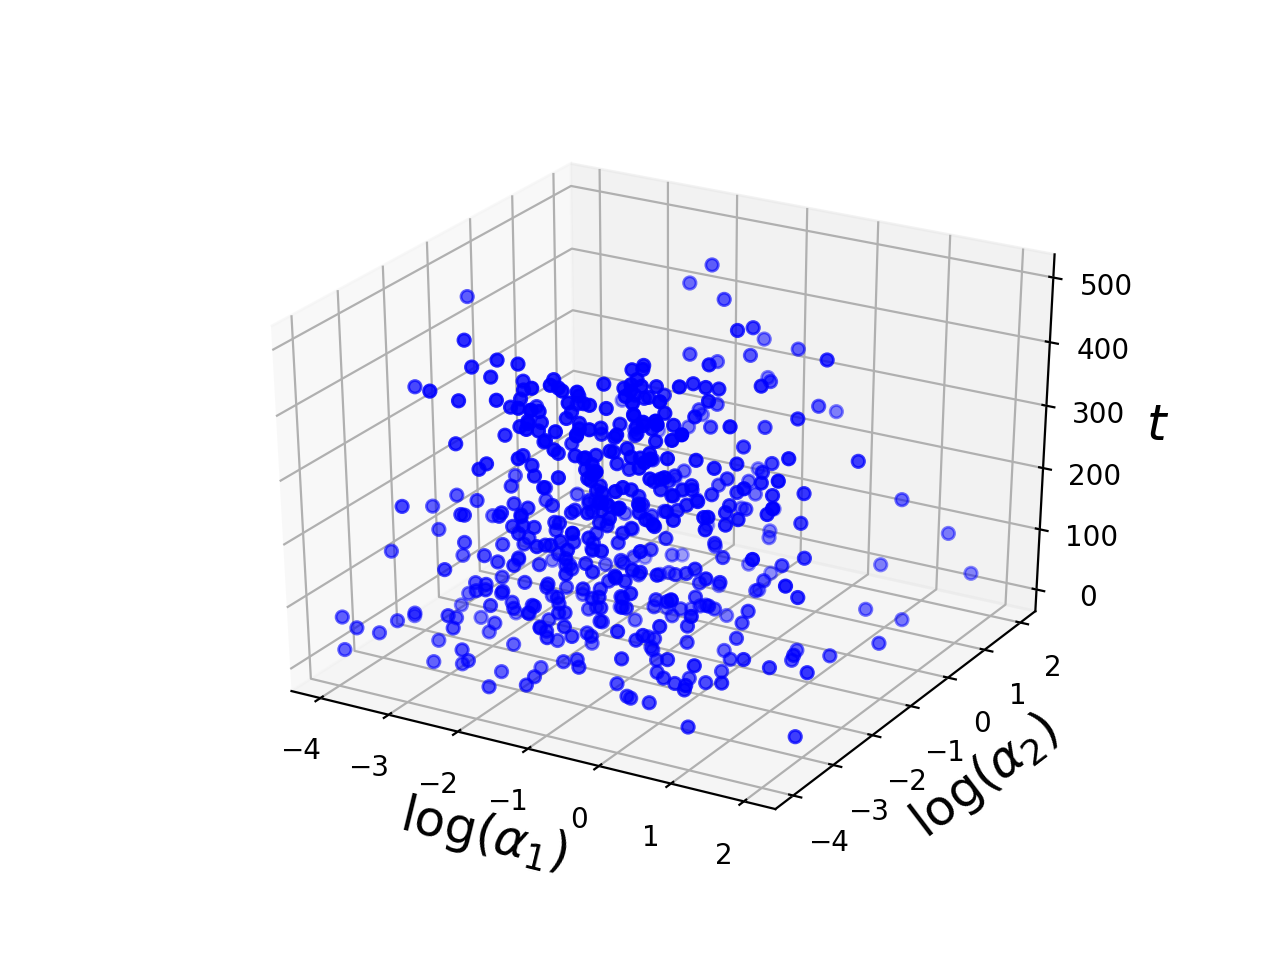

In [12]:
zs = [t['tid'] for t in trials.trials]
xs = [np.log(t['misc']['vals']['alpha1'][0]) for t in trials.trials]
ys = [np.log(t['misc']['vals']['alpha2'][0]) for t in trials.trials]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

_ = ax.scatter(xs, ys, zs, c='b', marker='o')

_ = ax.set_xlabel(r'$\log(\alpha_1)$', fontsize=18)
_ = ax.set_ylabel(r'$\log(\alpha_2)$', fontsize=18)
_ = ax.set_zlabel(r'$t$', fontsize=18)

Or we can plot the classification score (ROC AUC in this case) on the $z$-axis.

<IPython.core.display.Javascript object>


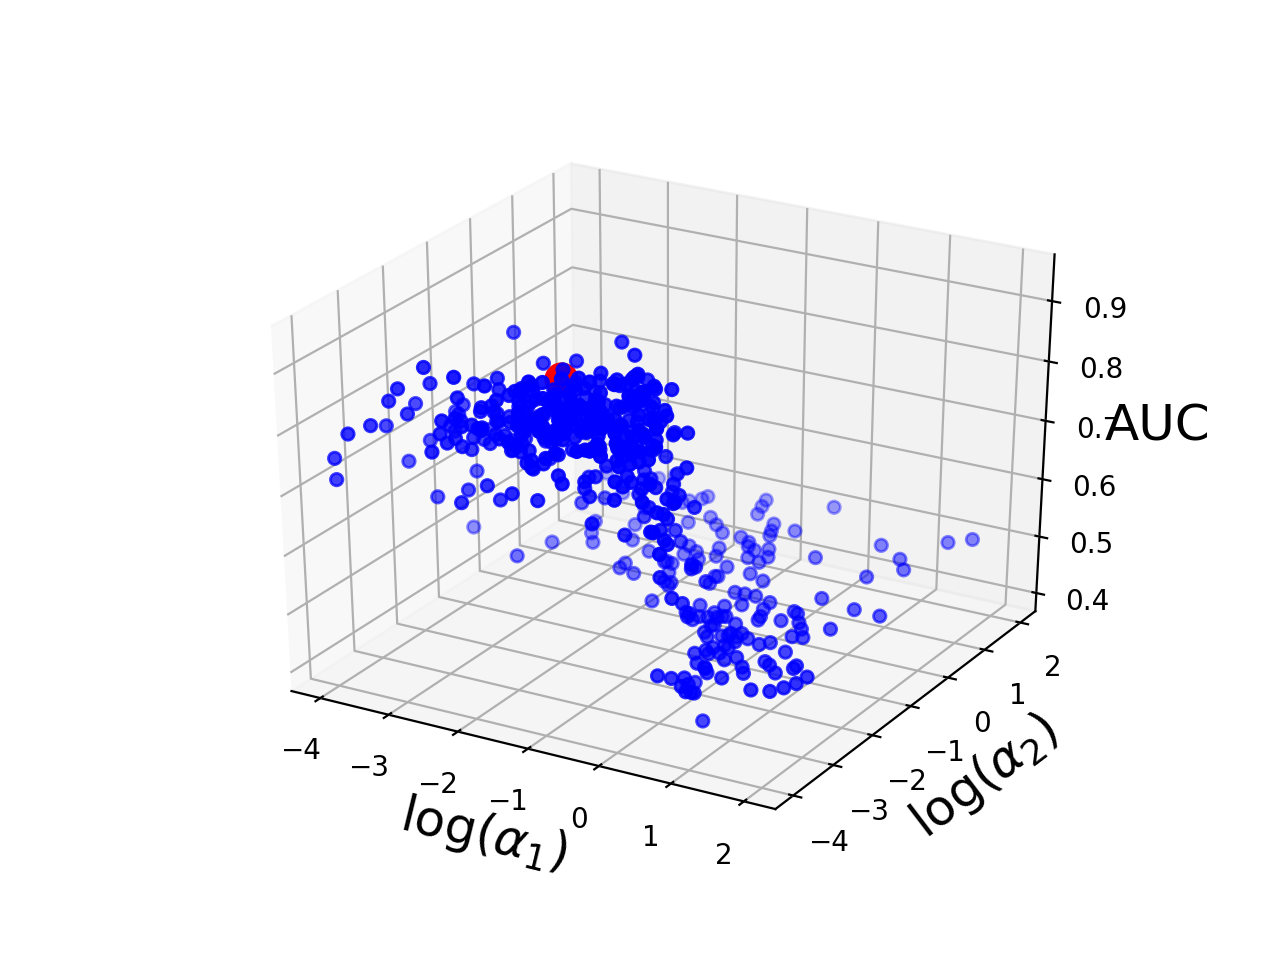

In [13]:
zs = [-t['result']['loss'] for t in trials.trials]
xs = [np.log(t['misc']['vals']['alpha1'][0]) for t in trials.trials]
ys = [np.log(t['misc']['vals']['alpha2'][0]) for t in trials.trials]

bestx = np.log(trials.best_trial['misc']['vals']['alpha1'][0])
besty = np.log(trials.best_trial['misc']['vals']['alpha2'][0])
bestz = -trials.best_trial['result']['loss']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_ = ax.scatter(xs, ys, zs, c='b', marker='o')
_ = ax.scatter(bestx, besty, bestz, c='r', marker='o', s=128)

_ = ax.set_xlabel(r'$\log(\alpha_1)$', fontsize=18)
_ = ax.set_ylabel(r'$\log(\alpha_2)$', fontsize=18)
_ = ax.set_zlabel('AUC', fontsize=18)

The function `fit_hyperparams_cv` splits up `x` and `y` using K-fold cross validation and runs `fit_hyperparams` on each split. The number of splits is specified with the `n_splits` parameter (default=10). To continue a previous run, you can specify a folder of pre-existing trials object pickles using the `trials_pickle_dir` parameter.

In [14]:
hp_cv_res = afqi.fit_hyperparams_cv(
    x, y, groups, max_evals_per_cv=500,
    score='roc_auc',
    trials_pickle_dir='./cv_trials_rs_42_rocauc',
    verbose=1, random_state=42, clf_threshold=0.5
)

100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


Let's summarize the results

In [17]:
template = '{stat:15s} {mean:7.5g} ({var:7.5g})'
test = [r.test for r in hp_cv_res]
train = [r.train for r in hp_cv_res]
test_acc = [t.accuracy for t in test]
test_auc = [t.auc for t in test]
test_aps = [t.avg_precision for t in test]
train_acc = [t.accuracy for t in train]
train_auc = [t.auc for t in train]
train_aps = [t.avg_precision for t in train]

print('Statistic         mean   (variance)')
print('--------------  ------- ------------')
print(template.format(stat='test accuracy', mean=np.mean(test_acc), var=np.var(test_acc)))
print(template.format(stat='test AUC', mean=np.mean(test_auc), var=np.var(test_auc)))
print(template.format(stat='test avg prec', mean=np.mean(test_aps), var=np.var(test_aps)))
print(template.format(stat='train accuracy', mean=np.mean(train_acc), var=np.var(train_acc)))
print(template.format(stat='train AUC', mean=np.mean(train_auc), var=np.var(train_auc)))
print(template.format(stat='train avg prec', mean=np.mean(train_aps), var=np.var(train_aps)))

Statistic         mean   (variance)
--------------  ------- ------------
test accuracy   0.84167 (0.024236)
test AUC        0.90833 (0.020069)
test avg prec   0.93667 (0.0091556)
train accuracy  0.92868 (0.0020578)
train AUC       0.98387 (0.00026275)
train avg prec  0.98572 (0.0002027)


And plot the classification probabilities for each cv split

In [18]:
p = figure(plot_width=700, plot_height=700)
p.title.text = 'Click on legend entries to hide the corresponding lines'

names = ['cv_idx = {i:d}'.format(i=i) for i in range(len(hp_cv_res))]

hover = HoverTool(
    tooltips=[("index", "$index"),],
    mode='vline',
)
hover.point_policy = 'snap_to_data'
hover.line_policy = 'nearest'

for res, color, name in zip(hp_cv_res, Spectral10, names):
    p.line(np.arange(len(y)), afqi.insight._sigmoid(x.dot(res.beta_hat)), line_width=2, color=color, alpha=0.8, legend=name)

p.line(np.arange(len(y)), y, line_width=3, alpha=0.8, legend='ground truth')
p.line(np.arange(len(y)), 0.5 * np.ones(len(y)), line_width=2, line_dash='dashed', alpha=0.8, legend='threshold')
p.add_tools(hover)
p.legend.location = 'top_right'
p.legend.click_policy = 'hide'

show(p)

# So which features were important

The functions `multicol2dicts` and `multicol2sets` take a pandas MultiIndex as input (the kind returned by `load_afq_data`) and return a list of dicts or sets of feature labels.

In [19]:
feature_dicts = afqi.multicol2dicts(cols, tract_symmetry=False)
feature_sets = afqi.multicol2sets(cols, tract_symmetry=False)

One can then pass these dicts or sets to other utility functions. For example, `sort_features` will return feature labels reverse sorted by the absolute value of the $\widehat{\beta}$ coefficient.

In [20]:
sorted_features = afqi.sort_features(
    feature_dicts,
    np.mean(np.array([res.beta_hat for res in hp_cv_res]), axis=0)
)

sorted_features

[({'metric': 'fa', 'nodeID': 34, 'tractID': 'Right Corticospinal'},
  -0.046587388448226665),
 ({'metric': 'fa', 'nodeID': 35, 'tractID': 'Right Corticospinal'},
  -0.0459131055518589),
 ({'metric': 'fa', 'nodeID': 33, 'tractID': 'Right Corticospinal'},
  -0.04563156778331813),
 ({'metric': 'fa', 'nodeID': 36, 'tractID': 'Right Corticospinal'},
  -0.04275812098439542),
 ({'metric': 'fa', 'nodeID': 38, 'tractID': 'Right Corticospinal'},
  -0.04246350549349479),
 ({'metric': 'fa', 'nodeID': 32, 'tractID': 'Right Corticospinal'},
  -0.04220617154519515),
 ({'metric': 'fa', 'nodeID': 37, 'tractID': 'Right Corticospinal'},
  -0.04185626977805401),
 ({'metric': 'fa', 'nodeID': 39, 'tractID': 'Right Corticospinal'},
  -0.040972613371382235),
 ({'metric': 'fa', 'nodeID': 40, 'tractID': 'Right Corticospinal'},
  -0.038919895973090424),
 ({'metric': 'fa', 'nodeID': 31, 'tractID': 'Right Corticospinal'},
  -0.036986413224902155),
 ({'metric': 'fa', 'nodeID': 41, 'tractID': 'Right Corticospinal'},

`select_group` is another useful utility function that (you guessed it) selects only the features corresponding to a group. It can select from the feature matrix `x` or the coefficient array `beta`. There are similar functions `select_groups` (plural), `remove_group`, and `remove_groups` (plural).

In [21]:
mean_beta = np.mean(np.array(
    [res.beta_hat for res in hp_cv_res]
), axis=0)

select_label = ('Right Corticospinal', 'fa')

afqi.select_group(x=mean_beta,
                  select_label=select_label,
                  label_sets=feature_sets)

array([-0.0004698 , -0.00107525, -0.00219656, -0.00183699, -0.00231524,
       -0.00428377, -0.00804105, -0.01061763, -0.00968205, -0.00674851,
       -0.00436293, -0.00219825, -0.00105216, -0.00056599, -0.00074609,
       -0.00114101, -0.00104397, -0.00082689, -0.00101146, -0.0012518 ,
       -0.00186815, -0.00314491, -0.00405561, -0.00480281, -0.00659281,
       -0.00941247, -0.01388185, -0.01904723, -0.02596734, -0.03247688,
       -0.03496428, -0.03698641, -0.04220617, -0.04563157, -0.04658739,
       -0.04591311, -0.04275812, -0.04185627, -0.04246351, -0.04097261,
       -0.0389199 , -0.03672699, -0.03454985, -0.03283972, -0.02914084,
       -0.02321946, -0.01980923, -0.01694072, -0.01244222, -0.01058548,
       -0.0086938 , -0.00568522, -0.00378879, -0.0024587 , -0.00251526,
       -0.00392421, -0.00528709, -0.00700066, -0.00891247, -0.00964112,
       -0.0088696 , -0.00766813, -0.00822966, -0.01061535, -0.01345542,
       -0.01750866, -0.02147859, -0.02519473, -0.02650224, -0.02

We can transform the large one-dimensional $\beta$ array into an ordered dict of $\beta$'s for each group by calling the function `beta_hat_by_groups`. With `drop_zeros=True` the ordered dict will contain keys for only those groups with non-zero $\beta$ values.

In [22]:
beta_hats = afqi.beta_hat_by_groups(mean_beta, columns=cols, drop_zeros=True)
print(beta_hats.keys())
print(beta_hats['Right Corticospinal'].keys())
print(beta_hats['Right Corticospinal']['fa'])

odict_keys(['Callosum Forceps Minor', 'Left Arcuate', 'Left Cingulum Hippocampus', 'Left IFOF', 'Left ILF', 'Left SLF', 'Right Arcuate', 'Right Cingulum Cingulate', 'Right Corticospinal'])
odict_keys(['fa', 'rd'])
[-0.0004698  -0.00107525 -0.00219656 -0.00183699 -0.00231524 -0.00428377
 -0.00804105 -0.01061763 -0.00968205 -0.00674851 -0.00436293 -0.00219825
 -0.00105216 -0.00056599 -0.00074609 -0.00114101 -0.00104397 -0.00082689
 -0.00101146 -0.0012518  -0.00186815 -0.00314491 -0.00405561 -0.00480281
 -0.00659281 -0.00941247 -0.01388185 -0.01904723 -0.02596734 -0.03247688
 -0.03496428 -0.03698641 -0.04220617 -0.04563157 -0.04658739 -0.04591311
 -0.04275812 -0.04185627 -0.04246351 -0.04097261 -0.0389199  -0.03672699
 -0.03454985 -0.03283972 -0.02914084 -0.02321946 -0.01980923 -0.01694072
 -0.01244222 -0.01058548 -0.0086938  -0.00568522 -0.00378879 -0.0024587
 -0.00251526 -0.00392421 -0.00528709 -0.00700066 -0.00891247 -0.00964112
 -0.0088696  -0.00766813 -0.00822966 -0.01061535 -0.01345

# Getting data out

You may want to visualize these coefficients within AFQ browser. The function `output_beta_to_afq` adds a new subject to the AFQ csv files with the supplied `beta_hat` values as the new subjects metric values in `nodes.csv`.

In [23]:
afqi.output_beta_to_afq(
    beta_hat=np.mean(np.array(
        [res.beta_hat for res in hp_cv_res]
    ), axis=0),
    columns=cols,
    workdir_in='../afqinsight/data/classification_data',
    workdir_out='../afqinsight/data_with_weights',
    scale_beta=True
)

OutputFiles(nodes_file='/Users/Adam/code/projects/afq/insight/afqinsight/data_with_weights/nodes.csv', subjects_file='/Users/Adam/code/projects/afq/insight/afqinsight/data_with_weights/subjects.csv')